## Example: Applying TigerTail to Bar Crawl: Detecting Heavy Drinking Data

In this notebook, we apply the TigerTail library to the "Bar Crawl: Detecting Heavy Drinking" data from https://archive.ics.uci.edu/dataset/515/bar+crawl+detecting+heavy+drinking. There are 3 datasets being used here:

* all_accelerometer_data_pids13.csv: 3 axes of accelerometer data tracking subject position (time series data)
* phone_types.csv: subject phone types
* clean_tac contains a .csv file of TAC (transdermal alcohol content) measurements for each subject (time series data)

The eventual goal is to predict times when a subject's TAC is high enough to indicate that they are drunk (based on a predetermined threshold), given a sample of accelerometer data. This notebook shows how to use TigerTail classes to help visualize patterns in the accelerometer data leading up to a occurrence of drunkenness.

First we import the necessary libraries:

In [1]:
import sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime

sys.path.insert(0, '../TT')
from tigertail import TimeFrame, TimeSeries, EventSeries

Then we load in the TAC data for subject SA0297 (we pick one subject at random for demo purposes).

In [2]:
SA0297_TAC_path = '../data/bar-crawl-detecting-heavy-drinking/clean_tac/SA0297_clean_TAC.csv'
SA0297_TAC_df = pd.read_csv(SA0297_TAC_path).set_index('timestamp')
# convert epoch time to datetime
SA0297_TAC_df.index = [datetime.fromtimestamp(i) for i in SA0297_TAC_df.index]
# SA0297_TAC_df.index.name = None
SA0297_TAC_df

,TAC_Reading
2017-05-02 11:18:43,-0.010229
2017-05-02 11:49:06,-0.002512
2017-05-02 11:54:23,0.003249
2017-05-02 11:59:39,0.005404
2017-05-02 12:04:55,0.003377
2017-05-02 12:10:11,-0.001451
2017-05-02 12:15:27,-0.005816
2017-05-02 12:20:43,-0.006248
2017-05-02 12:25:59,-0.001631
2017-05-02 12:31:15,0.005332


Now we load the accelerometer data into a DataFrame and set the timestamps as the index. The timestamps require a bit of preprocessing as seen in the try-except block.

In [3]:
accelerometer_path = '../data/bar-crawl-detecting-heavy-drinking/all_accelerometer_data_pids_13.csv'
accelerometer_df = pd.read_csv(accelerometer_path).set_index('time')
try:
    accelerometer_df.index = [datetime.fromtimestamp(i) for i in accelerometer_df.index]
except ValueError:
	accelerometer_df.index = [datetime.fromtimestamp(i/1000) for i in accelerometer_df.index]
accelerometer_df

,pid,x,y,z
1970-01-01 01:00:00.000,JB3156,0.000000,0.000000,0.000000
1970-01-01 01:00:00.000,CC6740,0.000000,0.000000,0.000000
2017-05-02 16:04:42.409,SA0297,0.075800,0.027300,-0.010200
2017-05-02 16:04:42.455,SA0297,-0.035900,0.079400,0.003700
2017-05-02 16:04:42.500,SA0297,-0.242700,-0.086100,-0.016300
...,...,...,...,...
2017-05-03 18:34:08.196,CC6740,-0.133956,0.124726,-0.010736
2017-05-03 18:34:08.220,CC6740,-0.100764,0.180872,0.046449
2017-05-03 18:34:08.245,CC6740,-0.131853,0.195934,0.181088
2017-05-03 18:34:08.270,CC6740,-0.149704,0.194482,0.202393


We filter the accelerometer DataFrame to just the entries for subject SA0297.

In [4]:
SA0297_mask = accelerometer_df['pid'] == 'SA0297'
SA0297_accelerometer_df = pd.DataFrame(accelerometer_df[SA0297_mask]).drop(['pid'], axis=1)
SA0297_accelerometer_df

,x,y,z
2017-05-02 16:04:42.409,0.0758,0.0273,-0.0102
2017-05-02 16:04:42.455,-0.0359,0.0794,0.0037
2017-05-02 16:04:42.500,-0.2427,-0.0861,-0.0163
2017-05-02 16:04:43.945,-0.2888,0.0514,-0.0145
2017-05-02 16:04:43.953,-0.0413,-0.0184,-0.0105
...,...,...,...
2017-05-03 17:18:55.596,-0.0107,0.0801,0.0840
2017-05-03 17:18:55.641,0.0132,0.0835,0.0493
2017-05-03 17:18:55.686,0.0480,-0.0071,0.1374
2017-05-03 17:18:55.731,0.0597,-0.0426,-0.1090


The following cell removes some duplicate entries from the DataFrame just created:

In [5]:
SA0297_accelerometer_df = SA0297_accelerometer_df.loc[~SA0297_accelerometer_df.index.duplicated(keep='first')]
SA0297_accelerometer_df

,x,y,z
2017-05-02 16:04:42.409,0.0758,0.0273,-0.0102
2017-05-02 16:04:42.455,-0.0359,0.0794,0.0037
2017-05-02 16:04:42.500,-0.2427,-0.0861,-0.0163
2017-05-02 16:04:43.945,-0.2888,0.0514,-0.0145
2017-05-02 16:04:43.953,-0.0413,-0.0184,-0.0105
...,...,...,...
2017-05-03 17:18:55.596,-0.0107,0.0801,0.0840
2017-05-03 17:18:55.641,0.0132,0.0835,0.0493
2017-05-03 17:18:55.686,0.0480,-0.0071,0.1374
2017-05-03 17:18:55.731,0.0597,-0.0426,-0.1090


We now create 2 TimeSeries objects using the TAC and accelerometer DataFrames. We also visualize the datasets as they are.

<Axes: >

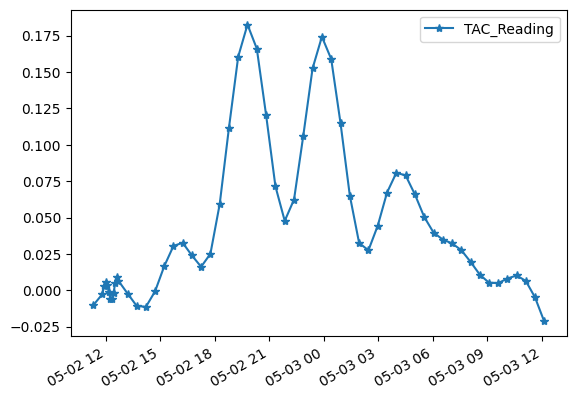

In [6]:
TAC_ts = TimeSeries(SA0297_TAC_df, agg_func=np.max)
accelerometer_ts = TimeSeries(SA0297_accelerometer_df, agg_func=np.mean)

TAC_ts.data.plot(marker="*")

We plot the three axes of accelerometer position data on three separate plots so that it's easier to get an idea of what's going on overall over time.

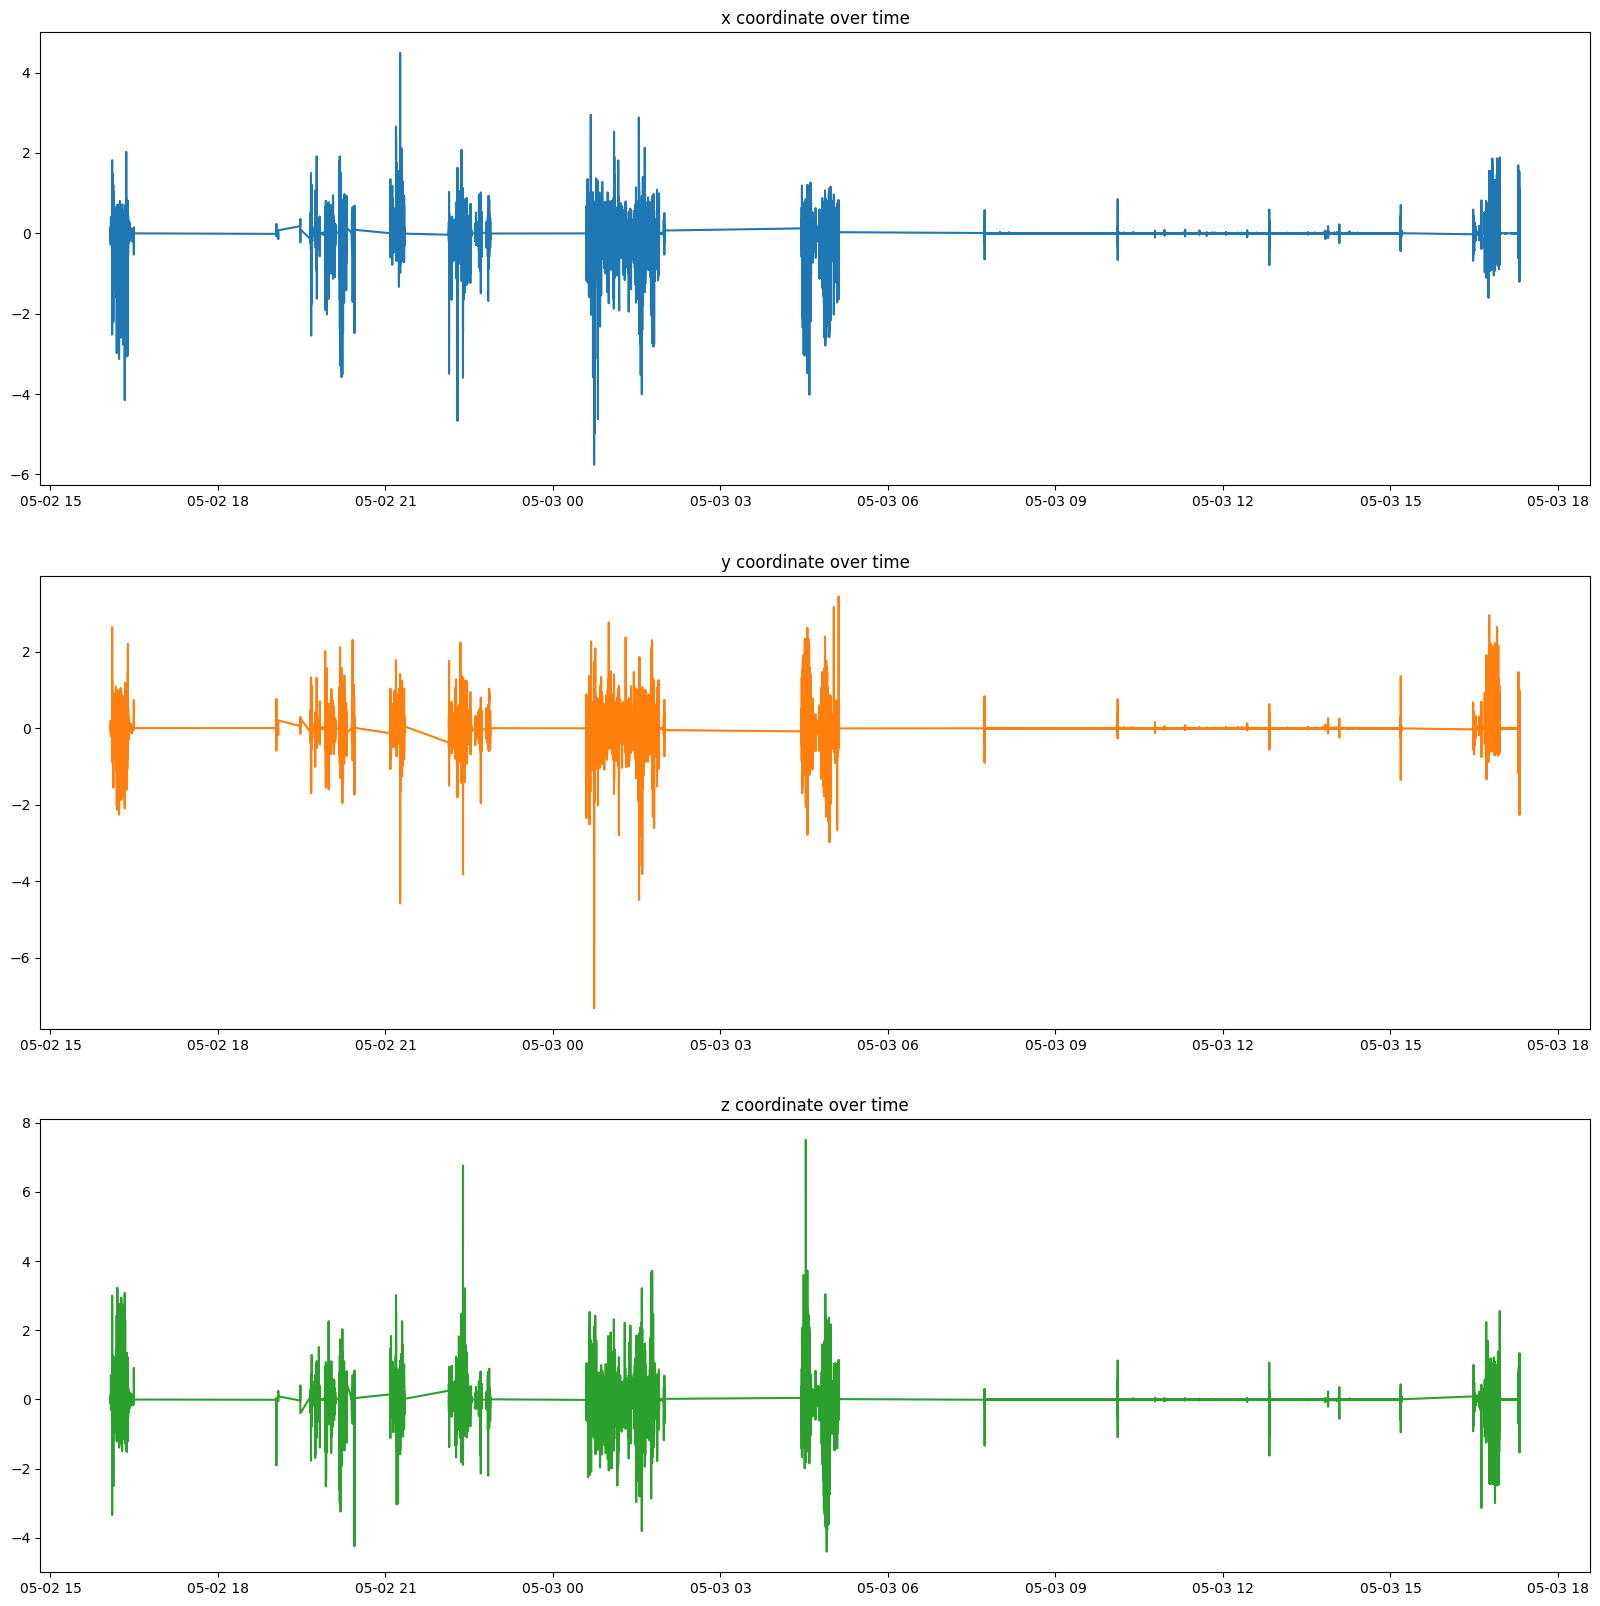

In [7]:
fig, axs = plt.subplots(3, 1, figsize=(20, 20))
axs[0].plot(accelerometer_ts.data.index, accelerometer_ts.data['x'])
axs[0].set_title('x coordinate over time')
axs[1].plot(accelerometer_ts.data.index, accelerometer_ts.data['y'], 'tab:orange')
axs[1].set_title('y coordinate over time')
axs[2].plot(accelerometer_ts.data.index, accelerometer_ts.data['z'], 'tab:green')
axs[2].set_title('z coordinate over time')
plt.show()

Now we create a TimeFrame object containing the TAC and accelerometer TimeSeries objects so that we can try windowing the datasets together. Since the TAC data measurements occur much more sparsely than the much finer accelerometer data, we choose to window both datasets using hour long intervals to better compare them.

In [8]:
tf = TimeFrame()
tf['TAC_ts'] = TAC_ts
tf['accelerometer_ts'] = accelerometer_ts

window_tf = tf.window('1h')
window_tf

ValueError: Length mismatch: Expected axis has 2 elements, new values have 4 elements

We make a plot of the windowed data to visualize the relationship between the TAC readings and accelerometer readings.

<Axes: >

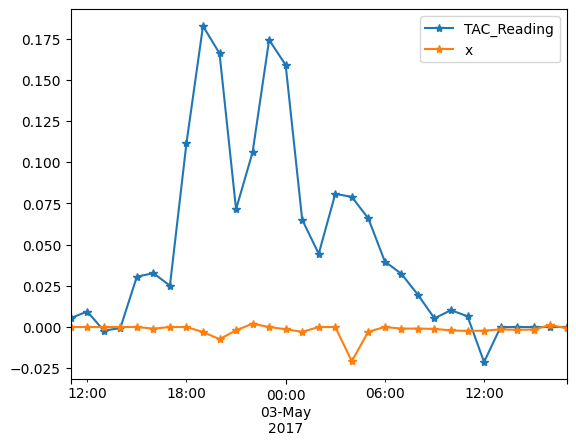

In [ ]:
window_tf.plot(marker='*')

We can see hours at which the average TAC spikes, so we would want to analyze and better visualize trends in the accelerometer position data during those times in order to predict periods of drunkenness from accelerometer data. We could add more functionality to the TimeFrame window function so that we can window the datasets together based on periods of high TAC readings, rather than just default frequencies.